# Spam fileter using Naive Bayesian algorithm
---

> Overview:
  we'll use the multinomial Naive Bayes algorithm to build a SMS spam filter model
* dataset of 5,572 SMS messages that are already classified by humans.
* from Tiago A. Almeida and José María Gómez Hidalgo available [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)


#### imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re

read data

In [2]:
sms = pd.read_csv("/Users/michaelschaid/Downloads/Guided Project Building a Spam Filter with Naive Bayes/SMSSpamCollection", sep='\t', header=None, names=['label', 'sms'])

In [3]:
print('shape')
print(sms.shape)
print(' \ndescription')
sms.describe()

shape
(5572, 2)
 
description


,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
print('ratio of non spam ("ham") and spam)')
sms.label.value_counts(normalize=True).round(2)

ratio of non spam ("ham") and spam)


ham     0.87
spam    0.13
Name: label, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(sms, test_size=0.2, random_state=1)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)



In [6]:
print('value count ratio in training data')
print(test_data['label'].value_counts(normalize=True))
print('\nvalue count ratio in test data')
print(train_data['label'].value_counts(normalize=True))

value count ratio in training data
ham     0.868161
spam    0.131839
Name: label, dtype: float64

value count ratio in test data
ham     0.86538
spam    0.13462
Name: label, dtype: float64


### Data clean goals:
* format all messages: no punctuation, all lower case
* create string list from each message
* create dataframe that includes category label with word count in each column

In [7]:



def tweak_sms(df): 
        """ cleans and generates new dataframe"""

        df=  (
                df
                .assign(sms_stripped= df['sms']
                                .str.replace('\W', ' ', regex='True')
                                .str.lower().str.split(" "))

                
                )


        """
        this whole section is a bit complicated, but the gist is that we generate columns for every 
        unique word, then for every index in df['sms'] we add 1 to the column for each unique word, if that word is present
        example->

        message of "this is a text message" results in 

        this:1
        is: 1
        a: 1
        text: 1
        message:1 

        and this a dataframne of :

        this | is | a | text | message
          1  | 1  | 1 |   1  |    1

        then we concat the new dataframe of word counts to the original df and return the full df. 

        """
        word_total = df['sms_stripped'].sum() #compile all words into one list


        vocab = set(word_total) #demove duplicates to get set of unique words

        word_counts_per_sms = {unique_word: [0] * len(df['sms_stripped']) for unique_word in vocab} #get counts

        for index, sms in enumerate(df['sms_stripped']):
                for word in sms:
                        word_counts_per_sms[word][index] += 1

        word_df = pd.DataFrame(word_counts_per_sms) #df from counts
        df_all= pd.concat([df, word_df], axis=1).drop(labels='', axis=1) #concat dfs

        return df_all

df_t=tweak_sms(train_data)



### Word clouds of Spam and Non-Spam(Ham) Messages

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

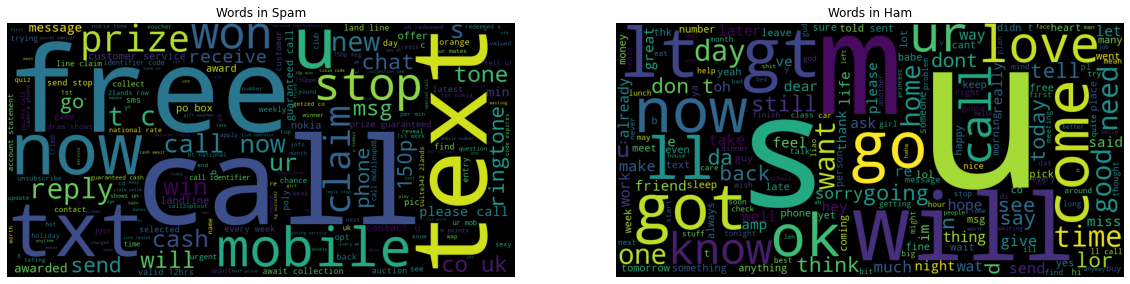

In [8]:

#convert list to string and generate

spam=train_data.query("label=='spam'")['sms'].str.replace('\W', ' ', regex='True').str.lower().sum()
ham=train_data.query("label=='ham'")['sms'].str.replace('\W', ' ', regex='True').str.lower().sum()

spamcloud=WordCloud(width = 1000, height = 500).generate(spam)
hamcloud=WordCloud(width = 1000, height = 500).generate(ham)

fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(20,16))
# plt.figure(figsize=(15,8))
ax[0].imshow(spamcloud)
ax[0].title.set_text("Words in Spam")
ax[0].axis("off")


ax[1].imshow(hamcloud)
ax[1].title.set_text("Words in Ham")
ax[1].axis("off")

# for i, ax in enumerate(ax.ravel()): # 2
#     ax.set_title("Plot #{}".format(i)) # 3
plt.tight_layout



### Naive Bayesian Algorithm 
\begin{equation*}
P(w_{1}|Spam)
= Number\:of\: times\: word\: w_i\: occurs\: in\: spam\: message
\end{equation*}

\begin{equation*}
P(w_{1}|Spam^c)
= Number\:of\: times\: word\: w_i\: occurs\: in\: non-spam\: message
\end{equation*}

\begin{equation*}
N_{Spam}
= Total\:number\:of\: words\:in\:spam\:message
\end{equation*} 

\begin{equation*}
N_{Spam^c}
= Total\:number\:of\: words\:in\:non-spam\:message
\end{equation*} 

\begin{equation*}
N_{Vocav}
= Total\:number\:of\: words\:in\:vocabulary
\end{equation*}

\begin{equation*}
\alpha=1\:(Laplace\:smoothing\:parameter)
\end{equation*}





\begin{equation*}
P(w_{1}|Spam) = \frac{N_{wi|Spam}+\alpha}{N_{Spam} + \alpha\cdot{N_{Vocab}}}
\end{equation*}

\begin{equation*}
P(w_{1}|Ham) = \frac{N_{wi|Ham}+\alpha}{N_{Ham} + \alpha\cdot{N_{Vocab}}}
\end{equation*}






**Probability of spam given words**
\begin{equation*}
 P(Spam|w_{1},w_{2},...,w_{n}) \propto P(Spam) \cdot \prod_{i=1}^n P(w_{i}|Spam)
\end{equation*}

**Probability of non-spam given words**
\begin{equation*}
 P(Ham|w_{1},w_{2},...,w_{n}) \propto P(Ham) \cdot \prod_{i=1}^n P(w_{i}|Ham)
\end{equation*}


## Functions to calculate Naive Bayes 

In [11]:

def n_counts(label:str)->int:

    """ func to calculate N label from trainng data"""
    label=label
    return train_data.query("label==@label").value_counts().sum()


def prob_label(label:str)->float:
    """ calculate word probably from ham + spam"""
    var = n_counts(label)
    return var/n_counts(['ham', 'spam'])

def calc_p_word_given_label(word:str, label:str, alpha=1)->float:

    
    n_labels=df_t.query("label==@label").sum().iloc[3:]
    if word not in n_labels:
        n_word__given_label = 0
    else:
        n_word__given_label=n_labels[word] 
    n_label=n_counts(label)
    n_total= n_counts(['ham', 'spam'])
    p_word_given_label = (n_word__given_label+alpha)/(n_label+alpha*n_total)
    return p_word_given_label


def calc_p_sms(sms:str, label:str)->float:
  
    p_word_sum = sum([calc_p_word_given_label(word, label) for word in sms if word !=''])
    p_label=prob_label(label)
    return p_label * p_word_sum

    

vocab=df_t.columns[2:]

test_sms=df_t['sms_stripped'][1]

# n_count_sms
p_test = calc_p_sms(test_sms,label='spam')
p_test



0.009743090757733391

#### Test functions

In [48]:
#test message
new_msg = 'WINNER!! This is the secret code to unlock the money: C3421.'
new_msg_strp= re.sub('\W', ' ', new_msg).lower().split(" ")
# print(new_msg_strp)
p_spam =  calc_p_sms(new_msg_strp, label='spam')
p_ham = calc_p_sms(new_msg_strp, label='ham')

print(f'spam {p_spam}, ham {p_ham}')

spam 0.029575338338365564, ham 0.4093746358502589


## Classifier functiion

In [15]:
def classifier(sms:str)->str:
    """takes input message and returns prediction of spam or ham """
    stripped_sms = re.sub('\W', ' ', sms).lower().split(" ")
    p_ham = calc_p_sms(stripped_sms, label='ham')
    p_spam = calc_p_sms(stripped_sms, label='spam')

    if p_ham > p_spam:
        return 'ham'
    elif p_spam > p_ham:
        return 'spam'
    else: 'unknown'
    

classifier(new_msg)

'ham'

In [50]:
test_data_10 =test_data.head(10)

test_data_10['pred']= test_data_10['sms'].apply(classifier)

/var/folders/qr/bdn0nwlj21vbcms1jk872y140000gn/T/ipykernel_847/1221443942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_10['pred']= test_data_10['sms'].apply(classifier)


In [51]:
test_data_10

,label,sms,pred
0,ham,"Yep, by the pretty sculpture",ham
1,ham,"Yes, princess. Are you going to make me moan?",ham
2,ham,Welp apparently he retired,ham
3,ham,Havent.,ham
4,ham,I forgot 2 ask ü all smth.. There's a card on ...,ham
5,ham,Ok i thk i got it. Then u wan me 2 come now or...,ham
6,ham,I want kfc its Tuesday. Only buy 2 meals ONLY ...,ham
7,ham,No dear i was sleeping :-P,ham
8,ham,Ok pa. Nothing problem:-),ham
9,ham,Ill be there on &lt;#&gt; ok.,ham
